##Applying different Models Now

In [1]:
import pandas as pd

# Load the dataset
file_path = '/content/final_mean_updated.csv'
data = pd.read_csv(file_path)

data.head()


,Name,Formula,#CH3,#CH2,#CH,#C,#OH,#C-O-C,#O=C,DBA,#N,#Hal,O:C,M / g/mol,Tm / K,Tg / K,Tg/Tm,Tm/Tg,#S,#branching
0,glucose,C6H12O6,0,1,4,1,5,0,1,1,0,0,1.0000,180.0,419.675,300.666667,0.716427,1.395815,0,5
1,dextrose,C6H12O6,0,1,4,1,5,0,1,1,0,0,1.0000,180.0,432.000,310.000000,0.717593,1.393548,0,5
2,tartaric acid,C4H6O6,0,0,2,2,4,0,2,2,0,0,1.5000,150.0,430.000,288.775000,0.671570,1.489049,0,4
3,"1,2,3-propanetricarboxylic acid",C6H8O6,0,2,1,3,3,0,3,3,0,0,1.0000,176.0,431.150,276.450000,0.641192,1.559595,0,4
4,"1,2,4-butanetricarboxylic acid",C7H10O6,0,3,1,3,3,0,3,3,0,0,0.8571,190.0,391.650,272.800000,0.696540,1.435667,0,4


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=['Name', 'Formula', 'Tg / K','Tm/Tg','Tg/Tm','#branching','#S'])
y_tg = data['Tg / K']  # Target for glass transition temperature

X_train_tg, X_test_tg, y_train_tg, y_test_tg = train_test_split(X, y_tg, test_size=0.10, random_state=42)

scaler = StandardScaler()

X_train_tg_scaled = scaler.fit_transform(X_train_tg)
X_test_tg_scaled = scaler.transform(X_test_tg)

# Checking the shapes of the training and testing sets
(X_train_tg_scaled.shape, X_test_tg_scaled.shape)


((360, 13), (40, 13))

#Glass Transition Temperature Prediction

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initializing models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42)  # Extra Trees model added here
}

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return mae, rmse, r2


In [10]:
results_tg = {}
for name, model in models.items():
    mae, rmse, r2 = train_and_evaluate_model(model, X_train_tg_scaled, y_train_tg, X_test_tg_scaled, y_test_tg)
    results_tg[name] = {"MAE": mae, "RMSE": rmse, "R^2": r2}
results_tg

print("Model Performance for Tg Prediction:")
print("-" * 60)
for model_name, metrics in results_tg.items():
    print(f"Model: {model_name}")
    print(f"    MAE: {metrics['MAE']:.4f}")
    print(f"    RMSE: {metrics['RMSE']:.4f}")
    print(f"    R^2: {metrics['R^2']:.4f}")
    print("-" * 60)

Model Performance for Tg Prediction:
------------------------------------------------------------
Model: Linear Regression
    MAE: 5.7700
    RMSE: 8.5639
    R^2: 0.9927
------------------------------------------------------------
Model: Random Forest
    MAE: 5.2828
    RMSE: 8.7758
    R^2: 0.9924
------------------------------------------------------------
Model: Gradient Boosting
    MAE: 6.0684
    RMSE: 8.3013
    R^2: 0.9932
------------------------------------------------------------
Model: XGBoost
    MAE: 6.4592
    RMSE: 9.8406
    R^2: 0.9904
------------------------------------------------------------
Model: Extra Trees
    MAE: 5.6442
    RMSE: 8.6761
    R^2: 0.9925
------------------------------------------------------------


In [11]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Define base models
estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(), SVR(C=1, gamma='auto'))),
    ('gb', GradientBoostingRegressor(n_estimators=10, random_state=42))
]

# Initialize Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1)
)

# Training the stacking model
stacking_regressor.fit(X_train_tg_scaled, y_train_tg)

# Evaluating the stacking model
predictions = stacking_regressor.predict(X_test_tg_scaled)
mae = mean_absolute_error(y_test_tg, predictions)
rmse = np.sqrt(mean_squared_error(y_test_tg, predictions))
r2 = r2_score(y_test_tg, predictions)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")


MAE: 6.2776, RMSE: 9.3088, R^2: 0.9914


In [12]:
from sklearn.model_selection import train_test_split

# Split training data for blending
X_train_base, X_holdout, y_train_base, y_holdout = train_test_split(
    X_train_tg_scaled, y_train_tg, test_size=0.2, random_state=42)

# Train base models
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_base, y_train_base)
predictions_rf = model_rf.predict(X_holdout)

model_svr = make_pipeline(StandardScaler(), SVR(C=1, gamma='auto'))
model_svr.fit(X_train_base, y_train_base)
predictions_svr = model_svr.predict(X_holdout)

# Create new feature set for the meta-model
X_meta = np.column_stack((predictions_rf, predictions_svr))

# Train meta-model
meta_model = Ridge(alpha=1)
meta_model.fit(X_meta, y_holdout)

# Use base models to generate features for test set
test_predictions_rf = model_rf.predict(X_test_tg_scaled)
test_predictions_svr = model_svr.predict(X_test_tg_scaled)

# Stack predictions and predict with meta-model
X_test_meta = np.column_stack((test_predictions_rf, test_predictions_svr))
final_predictions = meta_model.predict(X_test_meta)

# Evaluate
mae = mean_absolute_error(y_test_tg, final_predictions)
rmse = np.sqrt(mean_squared_error(y_test_tg, final_predictions))
r2 = r2_score(y_test_tg, final_predictions)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R^2: {r2:.4f}")


MAE: 6.4557, RMSE: 10.9191, R^2: 0.9882


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               1792      
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12161 (47.50 KB)
Trainable params: 12161 (47.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/800
3/3 [==============================] - 1s 113ms/step - loss: 61085.6250 - mae: 230.3421 - mse: 61085.6250 - val_loss: 63905.3203 - val_mae

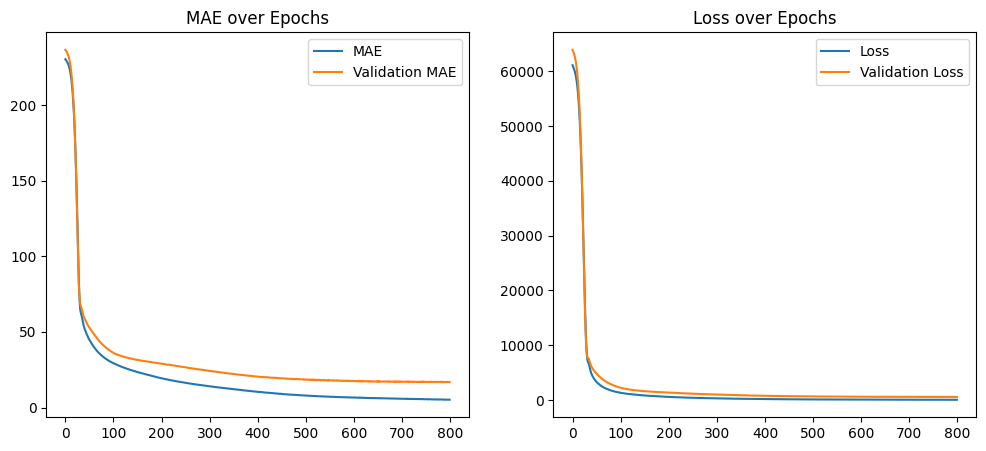

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define the neural network structure
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_tg_scaled.shape[1],)),  # Input layer
    Dense(64, activation='relu'),  # Hidden layer
    Dense(32, activation='relu'),  # Additional hidden layer
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train_tg_scaled, y_train_tg, epochs=800, batch_size=100, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
test_loss, test_mae, test_mse = model.evaluate(X_test_tg_scaled, y_test_tg, verbose=0)

# Predict using the trained model
test_predictions = model.predict(X_test_tg_scaled).flatten()

# Calculate R^2 score
test_r2 = r2_score(y_test_tg, test_predictions)

print(f"Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}, Test R^2: {test_r2:.4f}")

# Optionally, plot the training progress
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


## XGBoost giving the best model results

In [14]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define a parameter grid to search over
param_grid = {
    'max_depth': [3],
    'n_estimators': [150],
    'learning_rate': [0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.9]
}

# Initialize the XGBRegressor
xgb = XGBRegressor(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Perform the grid search on the training data
grid_search.fit(X_train_tg_scaled, y_train_tg)

# Get the best parameters
best_parameters = grid_search.best_params_

# Train a new XGBRegressor using the best parameters from the grid search
best_xgb = XGBRegressor(**best_parameters)
best_xgb.fit(X_train_tg_scaled, y_train_tg)

best_predictions = best_xgb.predict(X_test_tg_scaled)

# Predict on the test set with the best model
best_rmse = np.sqrt(mean_squared_error(y_test_tg, best_predictions))

# Calculate R^2 score with the best model
best_r2 = r2_score(y_test_tg, best_predictions)

# Calculate MAE with the best model
best_mae = mean_absolute_error(y_test_tg, best_predictions)

print("Best Parameters:", best_parameters)
print("Best RMSE:", best_rmse)
print("Best R^2 Score:", best_r2)
print("Best MAE:", best_mae)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=150, subsample=0.8; total time=   0.1s
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Best RMSE: 6.13292291957238
Best R^2 Score: 0.9962734520701776
Best MAE: 4.307576790425292


##Code to take user Input

In [ ]:
def predict_glass_transition_temperature(input_features):
    # Convert input_features dict to DataFrame
    input_df = pd.DataFrame([input_features])

    # Scale the input features using the previously fitted scaler
    input_scaled = scaler.transform(input_df)

    # Predict using the trained model
    predicted_tg = best_xgb.predict(input_scaled)

    return predicted_tg[0]

user_input = {
    '#CH3': 2,
    '#CH2': 4,
    '#CH': 0,
    '#C ': 0,
    '#OH': 0,
    '#C-O-C': 0,
    '#O=C': 0,
    'DBA': 0,
    '#N': 0,
    '#Hal': 0,
    'O:C': 0,
    'M / g/mol': 86.18,
    'Tm / K': 178,
    'Tg/Tm': 0.67,
    '#S': 0,
    '#branching': 0
}



#CH3	#CH2	#CH	#C	#OH	#C-O-C	#O=C	DBA	#N	#Hal	O:C	M / g/mol	#S	#branching
predicted_tg = predict_glass_transition_temperature(user_input)
print("Predicted Glass Transition Temperature:", predicted_tg)


Predicted Glass Transition Temperature: 107.14469
